In [ ]:
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
from gensim.models import KeyedVectors

In [13]:

file_path = 'file.csv'
data = pd.read_csv(file_path).iloc[:, 1:]


In [14]:
data.head()

,tweets,labels
0,ChatGPT: Optimizing Language Models for Dialog...,neutral
1,"Try talking with ChatGPT, our new AI system wh...",good
2,ChatGPT: Optimizing Language Models for Dialog...,neutral
3,"THRILLED to share that ChatGPT, our new model ...",good
4,"As of 2 minutes ago, @OpenAI released their ne...",bad


# With FastText

In [15]:


# Tokenizer
tokenizer = get_tokenizer('basic_english')

# Rename columns to 'text' and 'label' for consistency with the rest of the code
data = data.rename(columns={'tweets': 'text', 'labels': 'label'})

# Tokenize the text
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data['text']), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(text):
    return vocab(tokenizer(text))

# Create a label mapping
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}  # Reverse mapping for prediction
num_labels = len(label_mapping)

# Label pipeline
def label_pipeline(label):
    return label_mapping[label]

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, data, text_pipeline, label_pipeline):
        self.data = data
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['text'].iloc[idx]
        label = self.data['label'].iloc[idx]
        return self.text_pipeline(text), self.label_pipeline(label)

# Function to pad sequences and create batch
def pad_collate_batch(batch):
    text_list, label_list, lengths = [], [], []
    for (_text, _label) in batch:
        processed_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(torch.tensor(_label, dtype=torch.int64))
        lengths.append(processed_text.size(0))
    text_list = pad_sequence(text_list, padding_value=vocab["<pad>"], batch_first=True)
    return text_list, torch.tensor(label_list, dtype=torch.int64), torch.tensor(lengths, dtype=torch.int64)

# Split the data into training, validation, and test sets
# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create dataset and dataloader
train_dataset = TextDataset(train_data, text_pipeline, label_pipeline)
val_dataset = TextDataset(val_data, text_pipeline, label_pipeline)
test_dataset = TextDataset(test_data, text_pipeline, label_pipeline)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_batch)

# Load the FastText model using gensim
fasttext_model_path = 'C:/Users/kacpe/Desktop/Studia/AMLM/wiki-news-300d-1M.vec'  # Update this path
fasttext_model = KeyedVectors.load_word2vec_format(fasttext_model_path)

# Create an embedding matrix
embedding_matrix = torch.zeros(len(vocab), fasttext_model.vector_size)
for i, token in enumerate(vocab.get_itos()):
    if token in fasttext_model:
        embedding_matrix[i] = torch.tensor(fasttext_model[token])
    else:
        embedding_matrix[i] = torch.randn(fasttext_model.vector_size)

# Define the LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.embedding.weight.data.copy_(embedding_matrix)  # Copy FastText vectors to the embedding layer
        self.embedding.weight.requires_grad = False  # Freeze the embedding layer
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(hidden[-1])  # Apply dropout
        return self.fc(hidden)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
embed_dim = fasttext_model.vector_size  # Set embedding dimension
hidden_dim = 128  # Reduced hidden dimension
output_dim = num_labels  # Use the number of unique labels

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.6).to(device)  # Increased dropout rate

# Training and evaluation functions
def train(model, iterator, optimizer, criterion, epoch, max_episodes):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc=f'Epoch {epoch+1}', leave=False)
    for i, batch in enumerate(progress_bar):
        if i >= max_episodes:
            break
        text, labels, lengths = [x.to(device) for x in batch]
        optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / min(len(iterator), max_episodes)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            text, labels, lengths = [x.to(device) for x in batch]
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Reduced learning rate and added weight decay
criterion = nn.CrossEntropyLoss()

num_epochs = 20
max_episodes = 7000

train_losses, val_losses = [], []

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=3)


Epoch 1: Train Loss = 0.9453, Val Loss = 0.8775


Epoch 2: Train Loss = 0.8470, Val Loss = 0.8208


Epoch 3: Train Loss = 0.7906, Val Loss = 0.7822


Epoch 4: Train Loss = 0.7416, Val Loss = 0.7322


Epoch 5: Train Loss = 0.7017, Val Loss = 0.7029


Epoch 6: Train Loss = 0.6666, Val Loss = 0.6918


Epoch 7: Train Loss = 0.6359, Val Loss = 0.6542


Epoch 8: Train Loss = 0.6083, Val Loss = 0.6499


Epoch 9: Train Loss = 0.5815, Val Loss = 0.6262


Epoch 10: Train Loss = 0.5604, Val Loss = 0.6133


Epoch 11: Train Loss = 0.5373, Val Loss = 0.5950


Epoch 12: Train Loss = 0.5186, Val Loss = 0.5957


Epoch 13: Train Loss = 0.5011, Val Loss = 0.5842


Epoch 14: Train Loss = 0.4840, Val Loss = 0.5905


Epoch 15: Train Loss = 0.4688, Val Loss = 0.5710


Epoch 16: Train Loss = 0.4555, Val Loss = 0.5873


Epoch 17: Train Loss = 0.4437, Val Loss = 0.5717


Epoch 18: Train Loss = 0.4306, Val Loss = 0.5790
Early stopping triggered


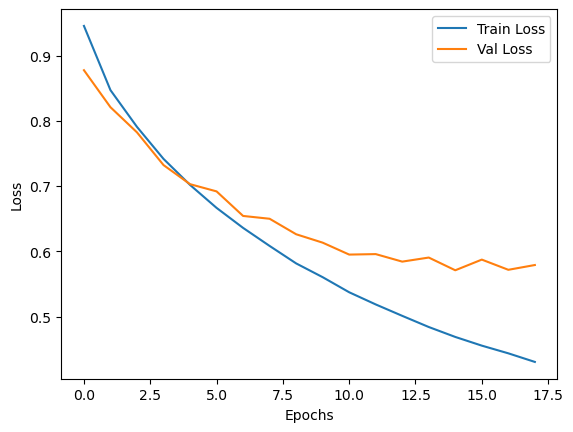

In [16]:
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, epoch, max_episodes)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    if early_stopping.should_stop(val_loss):
        print("Early stopping triggered")
        break

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Test Accuracy: 0.7732
Predicted: bad, Actual: bad
Predicted: neutral, Actual: bad
Predicted: bad, Actual: bad
Predicted: bad, Actual: bad
Predicted: neutral, Actual: good
Predicted: bad, Actual: bad
Predicted: neutral, Actual: neutral
Predicted: bad, Actual: bad
Predicted: neutral, Actual: neutral
Predicted: good, Actual: good


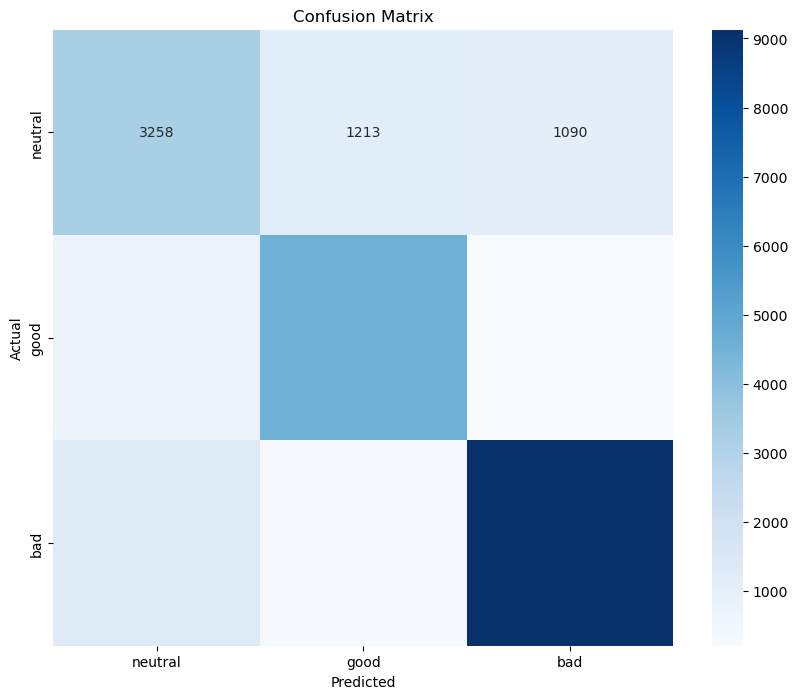

In [17]:
# Function to make predictions
def predict(text):
    model.eval()
    with torch.no_grad():
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64).unsqueeze(0).to(device)
        text_length = torch.tensor([processed_text.size(1)], dtype=torch.int64).to(device)
        prediction = model(processed_text, text_length)
        predicted_label = prediction.argmax(dim=1).item()
        return reverse_label_mapping[predicted_label]

# Make predictions on the test set and calculate accuracy
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            text, labels, lengths = [x.to(device) for x in batch]
            preds = model(text, lengths)
            predicted_labels = preds.argmax(dim=1)
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    return accuracy, predictions, true_labels

# Run the test
accuracy, test_predictions, true_labels = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.4f}')

# If needed, convert the numerical predictions back to label names
test_predictions_labels = [reverse_label_mapping[pred] for pred in test_predictions]

# Display a few predictions
for i in range(10):
    print(f'Predicted: {test_predictions_labels[i]}, Actual: {reverse_label_mapping[true_labels[i]]}')

# Compute the confusion matrix
cm = confusion_matrix(true_labels, test_predictions)
cm_labels = [reverse_label_mapping[i] for i in range(num_labels)]

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=cm_labels, yticklabels=cm_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
torch.save(model, 'model_ft.pth')

# Without FastText


In [21]:

data = pd.read_csv(file_path).iloc[:, 1:]

# Tokenizer
tokenizer = get_tokenizer('basic_english')
data = data.rename(columns={'tweets': 'text', 'labels': 'label'})

# Tokenize the text
def yield_tokens(data_iter):
    for text in data_iter:
        yield tokenizer(text)

# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(data['text']), specials=["<unk>", "<pad>", "<bos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

def text_pipeline(text):
    return vocab(tokenizer(text))

# Create a label mapping
label_mapping = {label: idx for idx, label in enumerate(data['label'].unique())}
reverse_label_mapping = {idx: label for label, idx in label_mapping.items()}  # Reverse mapping for prediction
num_labels = len(label_mapping)

# Label pipeline
def label_pipeline(label):
    return label_mapping[label]

# Custom Dataset class
class TextDataset(Dataset):
    def __init__(self, data, text_pipeline, label_pipeline):
        self.data = data
        self.text_pipeline = text_pipeline
        self.label_pipeline = label_pipeline

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data['text'].iloc[idx]
        label = self.data['label'].iloc[idx]
        return self.text_pipeline(text), self.label_pipeline(label)

# Function to pad sequences and create batch
def pad_collate_batch(batch):
    text_list, label_list, lengths = [], [], []
    for (_text, _label) in batch:
        processed_text = torch.tensor(_text, dtype=torch.int64)
        text_list.append(processed_text)
        label_list.append(torch.tensor(_label, dtype=torch.int64))
        lengths.append(processed_text.size(0))
    text_list = pad_sequence(text_list, padding_value=vocab["<pad>"], batch_first=True)
    return text_list, torch.tensor(label_list, dtype=torch.int64), torch.tensor(lengths, dtype=torch.int64)

# Split the data into training, validation, and test sets
train_data, test_data = train_test_split(data, test_size=0.1, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# Create dataset and dataloader
train_dataset = TextDataset(train_data, text_pipeline, label_pipeline)
val_dataset = TextDataset(val_data, text_pipeline, label_pipeline)
test_dataset = TextDataset(test_data, text_pipeline, label_pipeline)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=pad_collate_batch)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_batch)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=pad_collate_batch)

# Define the LSTM model with dropout
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = self.dropout(hidden[-1])  # Apply dropout
        return self.fc(hidden)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

vocab_size = len(vocab)
embed_dim = 300  # Set embedding dimension
hidden_dim = 128  # Reduced hidden dimension
output_dim = num_labels  # Use the number of unique labels

model = LSTMClassifier(vocab_size, embed_dim, hidden_dim, output_dim, dropout=0.6).to(device)  # Increased dropout rate

# Training and evaluation functions
def train(model, iterator, optimizer, criterion, epoch, max_episodes):
    model.train()
    epoch_loss = 0
    progress_bar = tqdm(iterator, desc=f'Epoch {epoch+1}', leave=False)
    for i, batch in enumerate(progress_bar):
        if i >= max_episodes:
            break
        text, labels, lengths = [x.to(device) for x in batch]
        optimizer.zero_grad()
        predictions = model(text, lengths)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    return epoch_loss / min(len(iterator), max_episodes)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            text, labels, lengths = [x.to(device) for x in batch]
            predictions = model(text, lengths)
            loss = criterion(predictions, labels)
            epoch_loss += loss.item()
    return epoch_loss / len(iterator)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)  # Reduced learning rate and added weight decay
criterion = nn.CrossEntropyLoss()

num_epochs = 20
max_episodes = 7000

train_losses, val_losses = [], []

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0

    def should_stop(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=3)




Epoch 1: Train Loss = 0.8689, Val Loss = 0.6710


Epoch 2: Train Loss = 0.5986, Val Loss = 0.5433


Epoch 3: Train Loss = 0.4805, Val Loss = 0.4723


Epoch 4: Train Loss = 0.4070, Val Loss = 0.4219


Epoch 5: Train Loss = 0.3508, Val Loss = 0.3966


Epoch 6: Train Loss = 0.3073, Val Loss = 0.3535


Epoch 7: Train Loss = 0.2743, Val Loss = 0.3379


Epoch 8: Train Loss = 0.2485, Val Loss = 0.3249


Epoch 9: Train Loss = 0.2270, Val Loss = 0.3223


Epoch 10: Train Loss = 0.2100, Val Loss = 0.3112


Epoch 11: Train Loss = 0.1961, Val Loss = 0.3129


Epoch 12: Train Loss = 0.1852, Val Loss = 0.2884


Epoch 13: Train Loss = 0.1736, Val Loss = 0.2971


Epoch 14: Train Loss = 0.1661, Val Loss = 0.3027


Epoch 15: Train Loss = 0.1576, Val Loss = 0.3029
Early stopping triggered


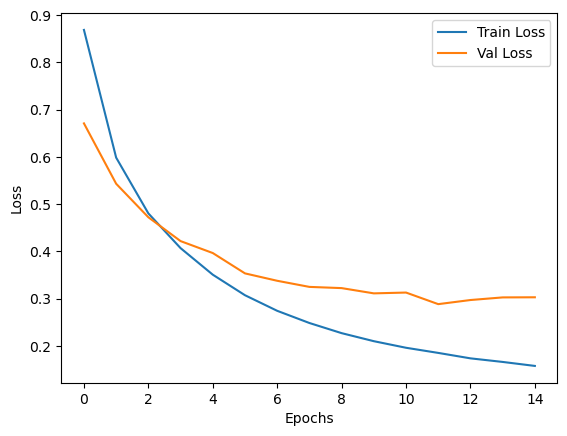

In [22]:

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, epoch, max_episodes)
    val_loss = evaluate(model, val_loader, criterion)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}')
    
    if early_stopping.should_stop(val_loss):
        print("Early stopping triggered")
        break

# Plot the training and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
def predict(text):
    model.eval()
    with torch.no_grad():
        processed_text = torch.tensor(text_pipeline(text), dtype=torch.int64).unsqueeze(0).to(device)
        text_length = torch.tensor([processed_text.size(1)], dtype=torch.int64).to(device)
        prediction = model(processed_text, text_length)
        predicted_label = prediction.argmax(dim=1).item()
        return reverse_label_mapping[predicted_label]

# Make predictions on the test set and calculate accuracy
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_loader:
            text, labels, lengths = [x.to(device) for x in batch]
            preds = model(text, lengths)
            predicted_labels = preds.argmax(dim=1)
            correct += (predicted_labels == labels).sum().item()
            total += labels.size(0)
            predictions.extend(predicted_labels.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    accuracy = correct / total
    return accuracy, predictions, true_labels

# Run the test
accuracy, test_predictions, true_labels = test_model(model, test_loader)
print(f'Test Accuracy: {accuracy:.4f}')

# If needed, convert the numerical predictions back to label names
test_predictions_labels = [reverse_label_mapping[pred] for pred in test_predictions]

# Display a few predictions
for i in range(10):
    print(f'Predicted: {test_predictions_labels[i]}, Actual: {reverse_label_mapping[true_labels[i]]}')

# Compute the confusion matrix
cm = confusion_matrix(true_labels, test_predictions)
cm_labels = [reverse_label_mapping[i] for i in range(num_labels)]

Test Accuracy: 0.9039
Predicted: bad, Actual: bad
Predicted: bad, Actual: bad
Predicted: bad, Actual: bad
Predicted: bad, Actual: bad
Predicted: good, Actual: good
Predicted: bad, Actual: bad
Predicted: neutral, Actual: neutral
Predicted: bad, Actual: bad
Predicted: neutral, Actual: neutral
Predicted: good, Actual: good


In [24]:
torch.save(model, 'model.pth')